In [48]:
!pip install vaderSentiment
!pip install plotly

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Importing Libraries


In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import re
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load Dataset

In [50]:
df = pd.read_csv("climate_nasa.csv")

# Explore dataset
df.head(10)

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."
5,2022-09-15T17:10:57.000Z,4,191055fb869d185092abf1405f0b2f4abe73bcaa9beb85...,1.0,Excellent example...very relatable to the Gen ...
6,2022-09-07T17:31:25.000Z,10,a9117191b443a0494349d21508a3de7df675250b786612...,NaN,I am so proud of whoever created this content....
7,2022-09-07T18:07:53.000Z,1,39c3ec5a079b6b1a62577a1d13d4e8f894c5525575b85d...,21.0,Has the Earth ever had a concentration of over...
8,2022-09-07T22:45:56.000Z,0,1492464caa9b6757f6e740a6cc8f75a44614645e9f6c64...,NaN,"Yes, and not even half a cup later that poor s..."
9,2022-09-07T16:30:55.000Z,4,31fd4cfea1a56eb21ad6a86ce4ed94e6a15e654b3557bf...,8.0,Historical co2 data would make it an interesti...


In [51]:
# Describe the data
df.describe()

,likesCount,commentsCount
count,522.000000,244.000000
mean,4.720307,8.696721
std,12.053556,12.266176
min,0.000000,1.000000
25%,0.000000,2.000000
50%,1.000000,5.000000
75%,4.000000,10.000000
max,126.000000,93.000000


## Data Preprocessing.

### Handling missing values.

In [52]:
total_missing = df.isnull().sum()
total_missing

,0
date,0
likesCount,0
profileName,0
commentsCount,278
text,18


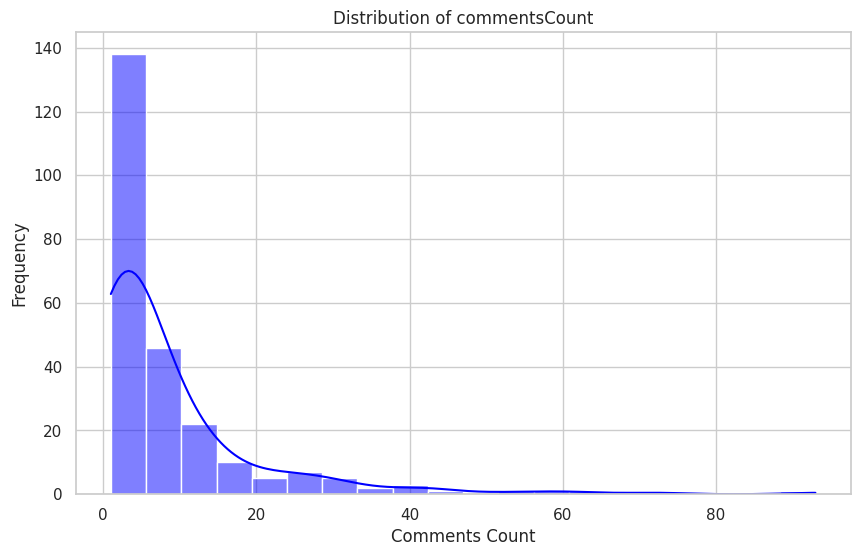

In [53]:
# visualising the data for skewness.
# Plot histogram for commentsCount
plt.figure(figsize=(10, 6))
sns.histplot(df['commentsCount'], bins=20, kde=True, color='blue')
plt.title('Distribution of commentsCount')
plt.xlabel('Comments Count')
plt.ylabel('Frequency')
plt.show()

*   From the above graph we can detect the dataset "commentsCount" is positively skewed.
*   Handling the missing values using median imputation. Median imputation works good for skewed data.


In [54]:
# Check for missing values in commentsCount
print(f"Missing values before: {df['commentsCount'].isnull().sum()}")

# Replace missing values with the median of the column
median_value = df['commentsCount'].median()
df['commentsCount'].fillna(median_value, inplace=True)

# Verify that missing values are handled
print(f"Missing values after: {df['commentsCount'].isnull().sum()}")

Missing values before: 278
Missing values after: 0


In [55]:
# Handling missing values from Text column.
# Replacing the missing values with empty strings in "Text" column.
df['text'].fillna('', inplace=True)

In [56]:
# Counting total missing values after processing.
total_missing = df.isnull().sum()
total_missing

,0
date,0
likesCount,0
profileName,0
commentsCount,0
text,0


### Preprocessing the text data.

In [57]:
# Lowercase conversion
# Convert all text to lowercase
df['text'] = df['text'].str.lower()

# Remove special characters, punctuation, and extra spaces
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Remove numbers
df['text'] = df['text'].apply(lambda x: re.sub(r'\d+', '', x))

# Tokenize the text into words
df['text'] = df['text'].apply(lambda x: x.split())
print(df[['text']].head())


                                                text
0  [neat, comparison, i, have, not, heard, it, be...
1  [an, excellent, way, to, visualise, the, invis...
2  [does, the, coghg, in, the, troposphere, affec...
3  [excellent, post, i, defo, feel, the, differen...
4  [yes, and, carbon, dioxide, does, not, harm, t...


### Removing Stopwords from text.

In [58]:
# Removing Stopwords from Text.
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stopwords
df['text'] = df['text'].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)
print(df[['text']].head())

# Steamming
from nltk.stem import PorterStemmer

# Initialize Stemmer
stemmer = PorterStemmer()

# Apply stemming
df['text'] = df['text'].apply(
    lambda tokens: [stemmer.stem(word) for word in tokens]
)
print(df[['text']].head())


                                                text
0  [neat, comparison, heard, would, say, co, like...
1     [excellent, way, visualise, invisible, thanks]
2  [coghg, troposphere, affect, stratosphere, war...
3  [excellent, post, defo, feel, difference, one,...
4  [yes, carbon, dioxide, harm, earth, like, peop...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text
0  [neat, comparison, heard, would, say, co, like...
1               [excel, way, visualis, invis, thank]
2  [coghg, tropospher, affect, stratospher, warme...
3  [excel, post, defo, feel, differ, one, drink, ...
4  [ye, carbon, dioxid, harm, earth, like, peopl,...


### Lemmatization

In [59]:
from nltk.stem import WordNetLemmatizer

# Download WordNet resources
nltk.download('wordnet')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization
df['text'] = df['text'].apply(
    lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
)
print(df[['text']].head())



                                                text
0  [neat, comparison, heard, would, say, co, like...
1               [excel, way, visualis, invis, thank]
2  [coghg, tropospher, affect, stratospher, warme...
3  [excel, post, defo, feel, differ, one, drink, ...
4  [ye, carbon, dioxid, harm, earth, like, peopl,...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
# Combine tokens back into sentences
df['cleaned_text'] = df['text'].apply(lambda tokens: ' '.join(tokens))
print(df[['text', 'cleaned_text']].head())

                                                text  \
0  [neat, comparison, heard, would, say, co, like...   
1               [excel, way, visualis, invis, thank]   
2  [coghg, tropospher, affect, stratospher, warme...   
3  [excel, post, defo, feel, differ, one, drink, ...   
4  [ye, carbon, dioxid, harm, earth, like, peopl,...   

                                        cleaned_text  
0  neat comparison heard would say co like disco ...  
1                     excel way visualis invis thank  
2  coghg tropospher affect stratospher warmer tro...  
3  excel post defo feel differ one drink make fee...  
4  ye carbon dioxid harm earth like peopl make fa...  


In [61]:
df.head(10)

,date,likesCount,profileName,commentsCount,text,cleaned_text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,5.0,"[neat, comparison, heard, would, say, co, like...",neat comparison heard would say co like disco ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,5.0,"[excel, way, visualis, invis, thank]",excel way visualis invis thank
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,"[coghg, tropospher, affect, stratospher, warme...",coghg tropospher affect stratospher warmer tro...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,5.0,"[excel, post, defo, feel, differ, one, drink, ...",excel post defo feel differ one drink make fee...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"[ye, carbon, dioxid, harm, earth, like, peopl,...",ye carbon dioxid harm earth like peopl make fa...
5,2022-09-15T17:10:57.000Z,4,191055fb869d185092abf1405f0b2f4abe73bcaa9beb85...,1.0,"[excel, exampleveri, relat, gen, pop, complex,...",excel exampleveri relat gen pop complex topics...
6,2022-09-07T17:31:25.000Z,10,a9117191b443a0494349d21508a3de7df675250b786612...,5.0,"[proud, whoever, creat, content, plea, feel, g...",proud whoever creat content plea feel good today
7,2022-09-07T18:07:53.000Z,1,39c3ec5a079b6b1a62577a1d13d4e8f894c5525575b85d...,21.0,"[earth, ever, concentr, ppm]",earth ever concentr ppm
8,2022-09-07T22:45:56.000Z,0,1492464caa9b6757f6e740a6cc8f75a44614645e9f6c64...,5.0,"[ye, even, half, cup, later, poor, soul, gonna...",ye even half cup later poor soul gonna know
9,2022-09-07T16:30:55.000Z,4,31fd4cfea1a56eb21ad6a86ce4ed94e6a15e654b3557bf...,8.0,"[histor, co, data, would, make, interest, post]",histor co data would make interest post


## Exploratory Data Analysis

In [62]:
# Statastical Overview.
# Generate descriptive statistics for LikesCount and CommentsCount
numerical_stats = df[['likesCount', 'commentsCount']].describe()
print("Descriptive Statistics:")
print(numerical_stats)


Descriptive Statistics:
       likesCount  commentsCount
count  522.000000     522.000000
mean     4.720307       6.727969
std     12.053556       8.578124
min      0.000000       1.000000
25%      0.000000       5.000000
50%      1.000000       5.000000
75%      4.000000       5.000000
max    126.000000      93.000000


In [63]:
# Ensure the 'date' column is in datetime format
df['new_date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract year and month for trend analysis
df['year_month'] = df['new_date'].dt.to_period('M')

# Count posts per year and month
posting_trends = df['year_month'].value_counts().sort_index()
print("Posting Trends (Year-Month):")
print(posting_trends)


Posting Trends (Year-Month):
year_month
2020-09    160
2021-09     82
2021-10     14
2021-11     26
2022-09     27
2022-10     31
2022-11     14
2022-12     62
2023-01      8
2023-03      1
2023-04      1
2023-07     31
2023-08      1
2023-09      2
2023-12     62
Freq: M, Name: count, dtype: int64


## Visualization

### Distribution of LikesCount and CommentsCount

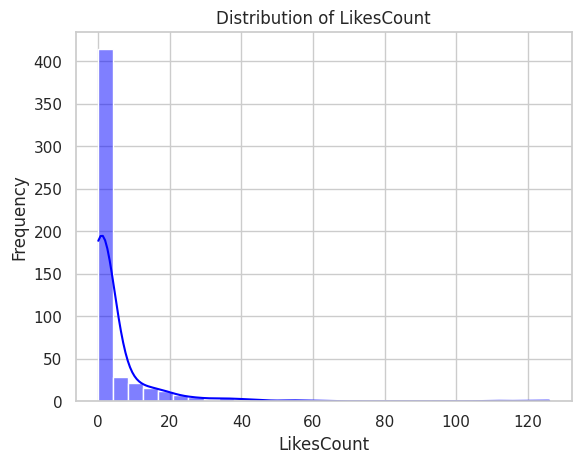

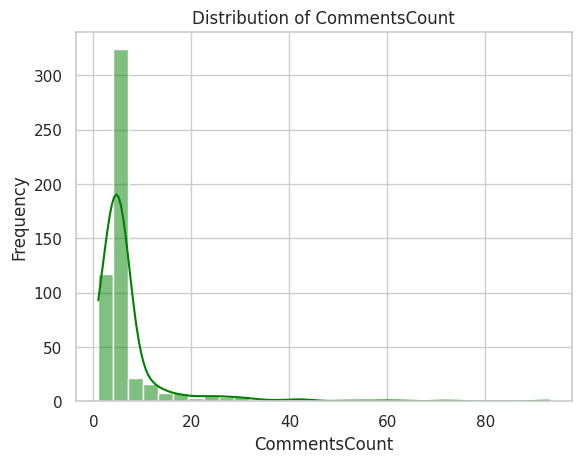

In [64]:
# Plot distribution of LikesCount
sns.histplot(df['likesCount'], kde=True, bins=30, color='blue')
plt.title('Distribution of LikesCount')
plt.xlabel('LikesCount')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of CommentsCount
sns.histplot(df['commentsCount'], kde=True, bins=30, color='green')
plt.title('Distribution of CommentsCount')
plt.xlabel('CommentsCount')
plt.ylabel('Frequency')
plt.show()

### Timeline of comments.

In [65]:
df.columns

Index(['date', 'likesCount', 'profileName', 'commentsCount', 'text',
       'cleaned_text', 'new_date', 'year_month'],
      dtype='object')

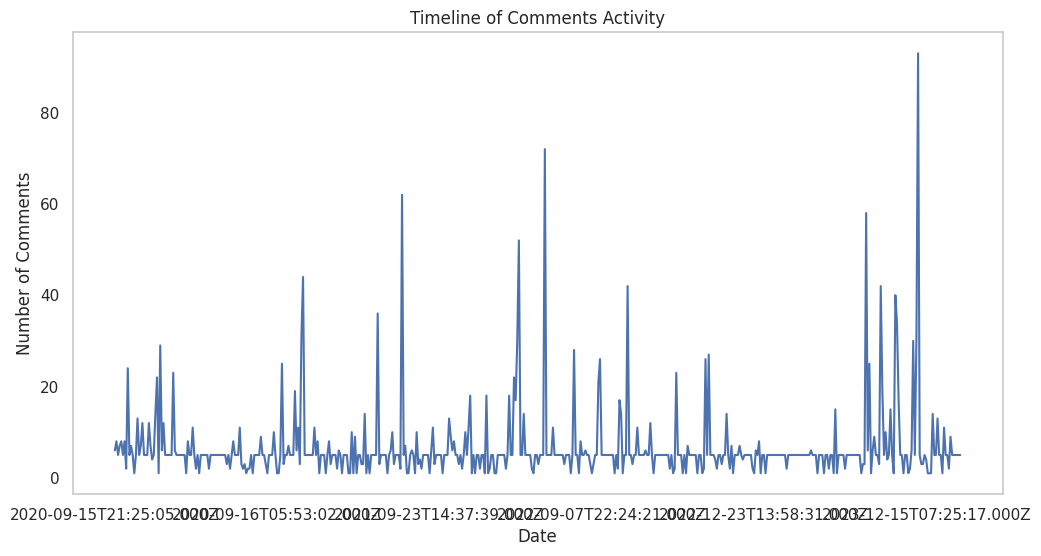

In [66]:
# Group by date and sum comments
comments_timeline = df.groupby('date')['commentsCount'].sum()

# Plot timeline of comments
plt.figure(figsize=(12, 6))
comments_timeline.plot()
plt.title('Timeline of Comments Activity')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.grid()
plt.show()


### Word Clouds for Frequent Words in Comments

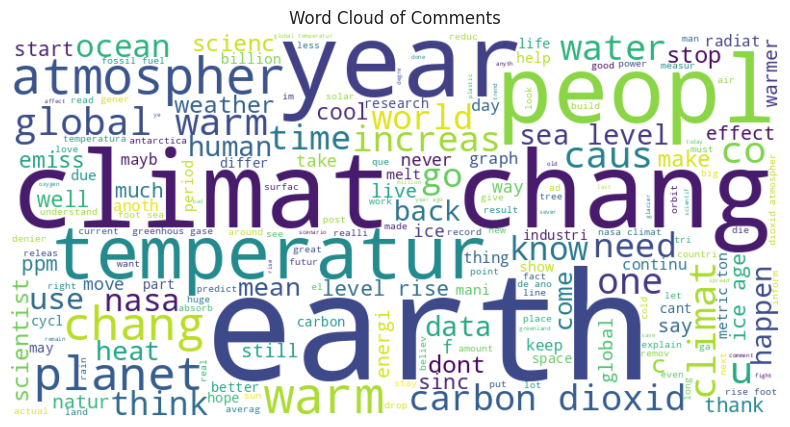

In [67]:
from wordcloud import WordCloud, STOPWORDS

# Combine all text in the comments
comments_text = ' '.join(df['cleaned_text'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(comments_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()


## Correlation Analysis

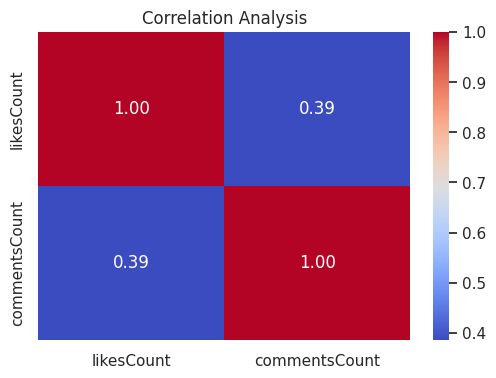

In [68]:
  # Calculate correlations
correlation_matrix = df[['likesCount', 'commentsCount']].corr()

# Display correlation matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Analysis')
plt.show()


## Engagement Analysis

In [69]:
# Define high engagement as posts with likesCount and commentsCount > 75th percentile
high_engagement = df[(df['likesCount'] > df['likesCount'].quantile(0.75)) &
                     (df['commentsCount'] > df['commentsCount'].quantile(0.75))]

print("High-Engagement Posts:")
print(high_engagement[['text', 'likesCount', 'commentsCount']])


High-Engagement Posts:
                                                  text  likesCount  \
4    [ye, carbon, dioxid, harm, earth, like, peopl,...          16   
10    [northern, hemispher, warm, southern, hemispher]           6   
42   [yet, mani, western, dont, believ, understand,...          12   
47   [born, spend, lot, time, outdoor, get, hotter,...          19   
82   [im, amaz, weve, warn, sinc, greenhous, gase, ...          33   
83   [last, year, varianc, reduc, half, probabl, me...          10   
102  [climat, chang, made, scenario, dem, seem, nev...          13   
104  [take, year, temperatur, read, planet, billion...          26   
105  [havent, seen, differ, anywher, go, ahead, pus...           6   
110  [worth, rememb, land, surfac, red, graph, warm...          43   
111  [three, erupt, dump, huge, amount, pollut, atm...           9   
130  [scientist, claim, head, ice, age, late, yea, ...           8   
146  [im, afraid, nasa, ad, list, agenc, credibl, w...           9 

###  Analyze Themes in High-Engagement Posts

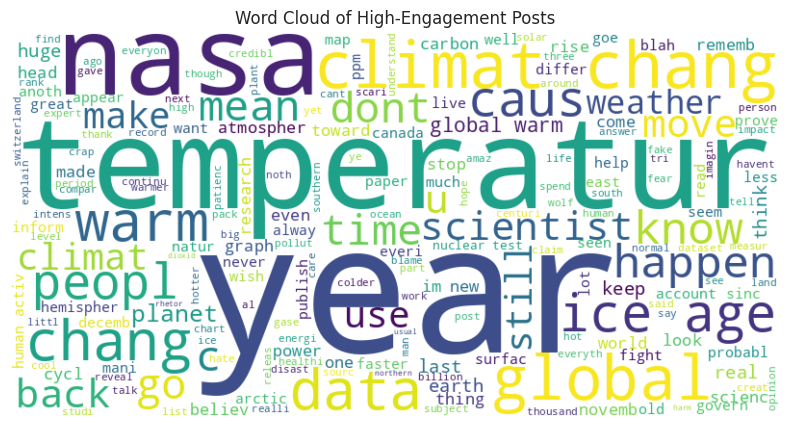

In [70]:
# Ensure all entries in the 'text' column are strings
high_engagement['text'] = high_engagement['text'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else str(x)
)

# Combine text from high-engagement posts
high_engagement_text = ' '.join(high_engagement['text'].dropna())

# Generate word cloud for high-engagement posts
wordcloud_high = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(high_engagement_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of High-Engagement Posts')
plt.show()


## Sentiment Analysis

In [71]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def get_sentiment_scores(text):
    return analyzer.polarity_scores(text)

# Apply the function to each text
df['sentiment_scores'] = df['cleaned_text'].apply(get_sentiment_scores)

# Split the scores into separate columns for easier analysis
df = pd.concat([df.drop(['sentiment_scores'], axis=1), df['sentiment_scores'].apply(pd.Series)], axis=1)

# Display the updated DataFrame
print(df[['neg', 'neu', 'pos', 'compound']])


       neg    neu    pos  compound
0    0.000  0.718  0.282    0.6705
1    0.000  0.353  0.647    0.6705
2    0.000  0.571  0.429    0.5423
3    0.231  0.559  0.210   -0.0772
4    0.346  0.524  0.131   -0.6249
..     ...    ...    ...       ...
517  0.000  0.408  0.592    0.4404
518  0.351  0.649  0.000   -0.4019
519  0.000  0.395  0.605    0.5574
520  0.000  1.000  0.000    0.0000
521  0.236  0.764  0.000   -0.5267

[522 rows x 4 columns]


In [72]:
df.head()

,date,likesCount,profileName,commentsCount,text,cleaned_text,new_date,year_month,neg,neu,pos,compound
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,5.0,"[neat, comparison, heard, would, say, co, like...",neat comparison heard would say co like disco ...,2022-09-07 17:12:32+00:00,2022-09,0.000,0.718,0.282,0.6705
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,5.0,"[excel, way, visualis, invis, thank]",excel way visualis invis thank,2022-09-08 14:51:13+00:00,2022-09,0.000,0.353,0.647,0.6705
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,"[coghg, tropospher, affect, stratospher, warme...",coghg tropospher affect stratospher warmer tro...,2022-09-07 17:19:41+00:00,2022-09,0.000,0.571,0.429,0.5423
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,5.0,"[excel, post, defo, feel, differ, one, drink, ...",excel post defo feel differ one drink make fee...,2022-09-08 00:51:30+00:00,2022-09,0.231,0.559,0.210,-0.0772
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"[ye, carbon, dioxid, harm, earth, like, peopl,...",ye carbon dioxid harm earth like peopl make fa...,2022-09-07 19:06:20+00:00,2022-09,0.346,0.524,0.131,-0.6249


In [73]:
# Assign sentiment category based on compound score
def assign_sentiment_category(compound):
    if compound > 0:
        return 'Positive'
    elif compound < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['compound'].apply(assign_sentiment_category)

# Display the DataFrame with sentiment categories
print(df[['text','sentiment_category']])

                                                  text sentiment_category
0    [neat, comparison, heard, would, say, co, like...           Positive
1                 [excel, way, visualis, invis, thank]           Positive
2    [coghg, tropospher, affect, stratospher, warme...           Positive
3    [excel, post, defo, feel, differ, one, drink, ...           Negative
4    [ye, carbon, dioxid, harm, earth, like, peopl,...           Negative
..                                                 ...                ...
517                                  [one, hope, peak]           Positive
518      [error, margin, temperatur, estim, year, ago]           Negative
519           [volenteerli, help, reduc, global, warm]           Positive
520                                     [sergio, yepe]            Neutral
521  [experienc, sever, abnorm, weather, pattern, c...           Negative

[522 rows x 2 columns]


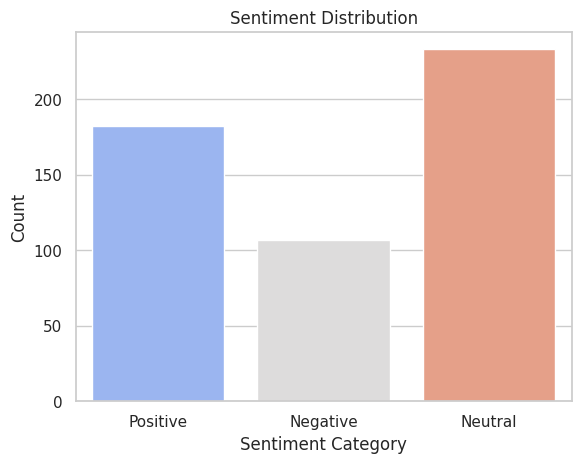

In [74]:
# Plot sentiment distribution
sns.countplot(data=df, x='sentiment_category', palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

## Trend Analysis.


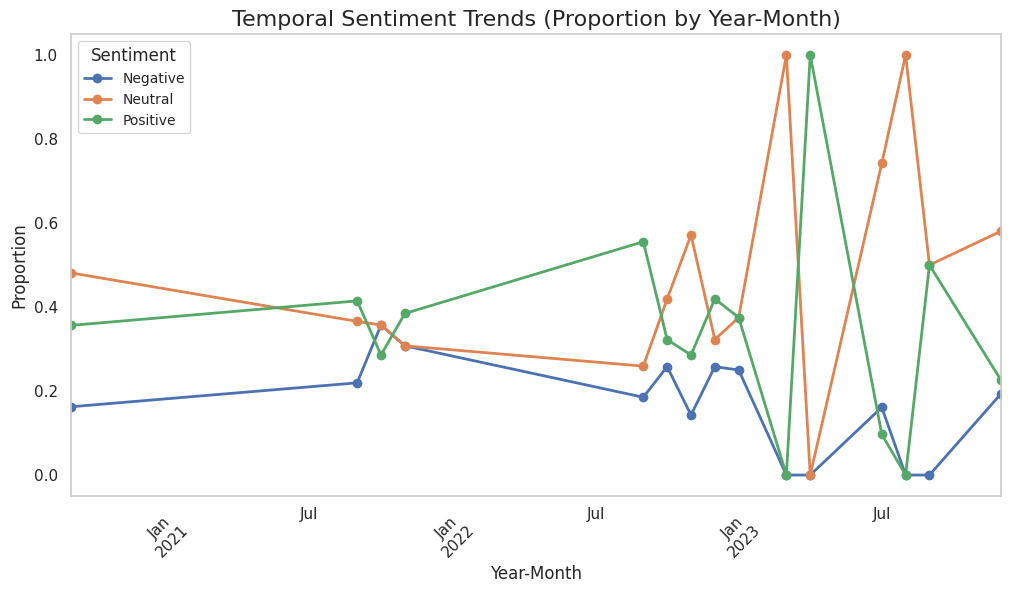

In [75]:
# Categorize sentiments
def categorize_sentiment(compound):
    if compound > 0:
        return 'Positive'
    elif compound == 0:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['compound'].apply(categorize_sentiment)

# Temporal Analysis: Group by year and month
temporal_trends = df.groupby(['year_month', 'sentiment']).size().reset_index(name='count')

# Pivot the data for line plotting
trend_pivot = temporal_trends.pivot(index='year_month', columns='sentiment', values='count').fillna(0)

# Normalize to calculate proportions
trend_pivot = trend_pivot.div(trend_pivot.sum(axis=1), axis=0)

# Plot Temporal Sentiment Trends
plt.figure(figsize=(12, 6))
trend_pivot.plot(kind='line', marker='o', ax=plt.gca(), linewidth=2)
plt.title('Temporal Sentiment Trends (Proportion by Year-Month)', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Sentiment', fontsize=10)
plt.grid()
plt.xticks(rotation=45)
plt.show()

## Topic Modelling.


In [76]:
# Sample cleaned text data
comments = df['cleaned_text'].dropna()

# Step 1: Vectorize the text using TF-IDF and Count Vectorizer
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,  # Ignore terms that appear in more than 95% of the documents
    min_df=2,     # Ignore terms that appear in less than 2 documents
    stop_words='english'  # Remove common stopwords
)
tfidf_matrix = tfidf_vectorizer.fit_transform(comments)

# Count Vectorizer
count_vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words='english'
)
count_matrix = count_vectorizer.fit_transform(comments)

# Step 2: Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Specify 5 topics
lda.fit(count_matrix)

# Step 3: Apply NMF for topic modeling
nmf = NMF(n_components=5, random_state=42)  # Specify 5 topics
nmf.fit(tfidf_matrix)

# Step 4: Extract topics and display top words for each
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

# Display topics for LDA
lda_topics = display_topics(lda, count_vectorizer.get_feature_names_out(), 10)
print("LDA Topics:")
for idx, topic in enumerate(lda_topics):
    print(f"Topic {idx + 1}: {topic}")

# Display topics for NMF
nmf_topics = display_topics(nmf, tfidf_vectorizer.get_feature_names_out(), 10)
print("\nNMF Topics:")
for idx, topic in enumerate(nmf_topics):
    print(f"Topic {idx + 1}: {topic}")



LDA Topics:
Topic 1: carbon atmospher year water level dioxid rise foot sea warm
Topic 2: earth planet chang year need age cool energi warm data
Topic 3: warm scienc dont global peopl happen think weather continu rain
Topic 4: earth climat human chang sun heat caus que time global
Topic 5: climat chang year global nasa warm temperatur peopl thank everi

NMF Topics:
Topic 1: climat chang nasa data scientist thank real scienc know post
Topic 2: warm global ice age caus think period dont scienc sinc
Topic 3: year temperatur graph ago data wow nasa degre increas record
Topic 4: happen caus cool ya thank lifetim futur everyon peopl probabl
Topic 5: earth time planet carbon human peopl need atmospher ppm life


In [77]:
!pip install pyLDAvis


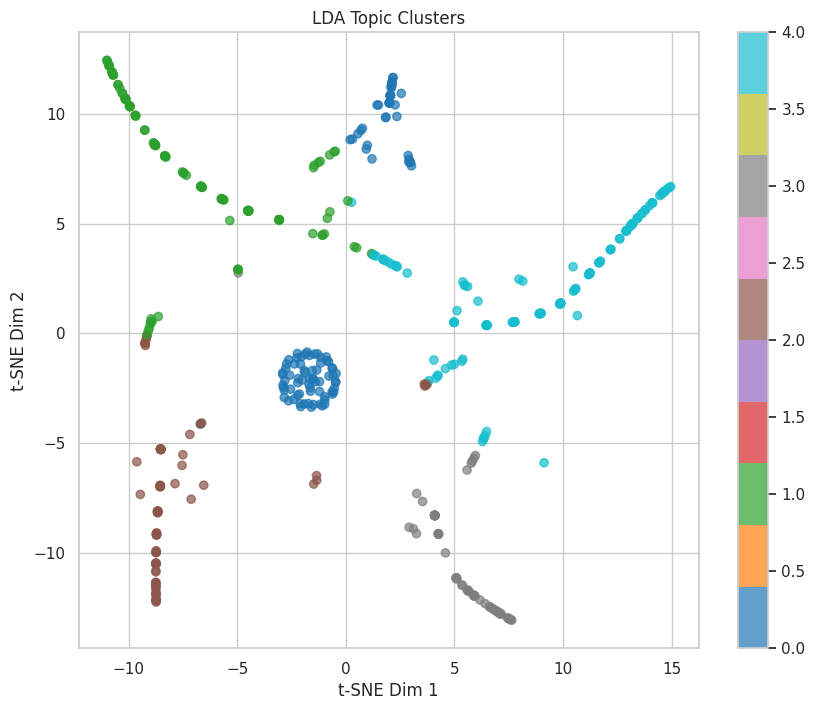

In [79]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions using t-SNE
topic_weights = lda.transform(count_matrix)
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_values = tsne_model.fit_transform(topic_weights)

# Plot topics
plt.figure(figsize=(10, 8))
plt.scatter(tsne_values[:, 0], tsne_values[:, 1], c=topic_weights.argmax(axis=1), cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("LDA Topic Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()
